# Implementation of word2vec on Stanford Sentiment Treebank (SST) dataset
“You shall know a word by the company it keeps” (J. R. Firth)
## Introduction
This notebook is a step by step guide on implementation of word2vec skipgram on Stanford Sentiment Treebank (SST) dataset, and is the solution to coding sections of [Assignment #2](http://web.stanford.edu/class/cs224n/assignments/a2.pdf) of Stanford's ["CS224n: Natural Language Processing with Deep Learning"](http://web.stanford.edu/class/cs224n/) course. Contents of this notebook are taken from the course materials. <br>
I recommend reading the original papers [1,2] and all the course materials on the word2vec (specially this [one]( http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf) before proceeding to implementation. But if you are looking a for a shortcut, the [this link](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) covers all the major points in both papers.

## Conda environment
First you need to create a conda virtual environment with all the necessary packages to run the code. Run the following command from within the repo directory to create a new env named "word2vecenv": 

Activate the "word2vecenv" that you just created:

Installing the IPython kernel in your env:

Now switch your notebook's kernel to "word2vec" env.

## Understanding negative sampling
 The original word2vec paper [1] proposed "Naive softmax loss" as objective function ($J$):

$- \sum^{2m}_{j=0,j \neq m} u^T_{c-m+j}v_c + 2m \log \sum_{k=1}^{|V|} \exp(u_k^T v_c) $

in which $v_c$ is the output word vector of the center word, $u_j$ is input word vector of outside word $j$, $|V|$ is the vocabulary size and $m$ is windows size. Note that everytime we update or evaluate $J$ we need to do a summation over the entire vocabulary (sum of $|V|$ terms), whihc is in order of millions and computationally huge! That's why author of the original paper came up with the idea of "Negative sampling loss" [2] to approximate the softmax normalization term (Sigma in the abvoe equation). The idea is that rather than looping over the entire vocabulary to do the summation, we generate negative samples and use them to estimate the objective function. We will use the latter in this notebook.

Consider a pair $(w, c)$ of word and context. Did this pair come from the training data? Let’s denote by $P(D = 1|w, c)$ the probability that $(w, c)$ came from the corpus data. Correspondingly, $P(D = 0|w, c)$ will be the probability that $(w, c)$ did not come from the corpus data. First, let’s model $P(D = 1|w, c)$ with the sigmoid function:

$P(D = 1|w, c,\theta) = \sigma (v_c^T v_w) = \frac{1}{1+exp(-v_c^T u_w)} $

and naturally if the pair did not come from the corpus, we will have:

$P(D = 0|w, c,\theta) = 1 - P(D = 0|w, c) =1 - \sigma (v_c^T v_w) = 1- \frac{1}{1+exp(-v_c^T u_w)} $

For every training step, instead of looping over the entire vocabulary, we can just sample several negative examples! We "sample" from a noise distribution ($P_n(w)$) whose probabilities match the ordering of the frequency of the vocabulary. For a given center word (vector), $v_c$, and outside (context) word, $u_o$, and $K$ negative samples, $\tilde{u}_k^T$, our objective function for Skip-gram model will be:

$J_{neg-sample} (v_c,u_o,U) = -\log \sigma(u^T_{o}v_c) - \sum_{k=1}^{K} \log \sigma (-\tilde{u}^T_{k}v_c) $

in which $U$ is the matrix of outside words. We will need partial derivatives of $J_{neg-sample} (v_c,u_o,U)$ wrt to $v_c$,$u_o$ and $u_k$ to for backpropagation (try to work out these derivatives from $J_{neg-sample} (v_c,u_o,U)$): 

$\partial J_{neg-sample} (v_c,u_o,U) / \partial v_c = -(1 - \sigma(u^T_o v_c))u_o + \sum_{k=1}^{K} (1-\sigma(-u_k^Tv_c)) u_k$

$\partial J_{neg-sample} (v_c,u_o,U) / \partial u_o = - (1- \sigma (u_o^T v_c))v_c$

$\partial J_{neg-sample} (v_c,u_o,U) / \partial u_k =  (1- \sigma (-u_k^T v_c))v_c$

We will use these derivatives to implement *negSamplingLossAndGradient* function

# Implementation

## Libraries

In [1]:
import random
import numpy as np
from utils.treebank import StanfordSentiment
from utils.gradcheck import gradcheck_naive
from utils.utils import normalizeRows, softmax
import pickle
import matplotlib
import matplotlib.pyplot as plt
import time
import glob
import os.path as op

# Check Python Version
import sys
assert sys.version_info[0] == 3
assert sys.version_info[1] >= 5

Run the following command line code to fetch the "Stanford Sentiment Treebank (SST): dataset:

## Take the data for a spin!

Let's take a look at the dataset first and see what's inside!

In [53]:
dataset.numSentences()

11855

There are 11855 sentences in the dataset.

In [57]:
len(dataset.tokens())

19539

and 19539 'tokens'. "dataset.tokens()" is mapping from tokens(words) to indices

In [73]:
dataset.tokens()['python']

4316

That is the index of 'python' in our dictionary!

## 1. Naive softmax implementation

### Sigmoid function
Good ol' sigmoid function which we will use to calculate the loss:

In [2]:
def sigmoid(x):
    """
    Arguments:
    x -- A scalar or numpy array.
    Return:
    s -- sigmoid(x)
    """
    sig_x=1/(1+np.exp(-x))

    return sig_x

### Negative sampler:
We are going to define *getNegativeSamples* to draw random negative samples from the dataset:

In [3]:
def getNegativeSamples(outsideWordIdx, dataset, K):
    """ Samples K indexes which are not the outsideWordIdx """

    negSampleWordIndices = [None] * K
    for k in range(K):
        newidx = dataset.sampleTokenIdx()
        while newidx == outsideWordIdx:
            newidx = dataset.sampleTokenIdx()
        negSampleWordIndices[k] = newidx
    return negSampleWordIndices

### Negative sampling loss and gradient:
We are going to use $\partial J_{neg-sample} (v_c,u_o,U) / \partial v_c$, $\partial J_{neg-sample} (v_c,u_o,U) / \partial u_o$ and $\partial J_{neg-sample} (v_c,u_o,U) / \partial u_k$ that we derived above to implement calculate the loss and gradient:

In [4]:
def negSamplingLossAndGradient(
    centerWordVec,
    outsideWordIdx,
    outsideVectors,
    dataset,
    K=10
                               ):
    """ Negative sampling loss function for word2vec models
    """

    negSampleWordIndices = getNegativeSamples(outsideWordIdx, dataset, K)
    indices = [outsideWordIdx] + negSampleWordIndices
    
    u_ws=outsideVectors[indices,:]
    u_ws[1:,:]=-u_ws[1:,:]
    sigmoid_uws=sigmoid(u_ws@centerWordVec.reshape(-1,1)).squeeze()
    loss= -np.log(sigmoid_uws).sum()
    
    
    gradCenterVec=(sigmoid_uws[0]-1)*u_ws[0,:]
    for row in range(1,u_ws.shape[0]):
        gradCenterVec=gradCenterVec-(1-sigmoid_uws[row])*u_ws[row,:]
        
        
    gradOutsideVecs=np.zeros(outsideVectors.shape)
    gradOutsideVecs[indices[0],:]=((sigmoid_uws[0]-1)*centerWordVec).reshape(-1,)
 
    for i,idx in enumerate(indices[1:]):
        gradOutsideVecs[idx,:]=gradOutsideVecs[idx,:]+((1-sigmoid_uws[i+1])*centerWordVec).reshape(-1,)
   

    return loss, gradCenterVec, gradOutsideVecs

### Skipgram
Given a minibatch including a center word and a list of outside words form the dataset, we will implement the *skipgram* function to calculate the loss and gradients:

In [5]:
def skipgram(currentCenterWord, windowSize, outsideWords, word2Ind,
             centerWordVectors, outsideVectors, dataset,
             word2vecLossAndGradient=negSamplingLossAndGradient):
    """ Skip-gram model

    Arguments:
    currentCenterWord -- a string of the current center word
    windowSize -- integer, context window size
    outsideWords -- list of no more than 2*windowSize strings, the outside words
    word2Ind -- a dictionary that maps words to their indices in
              the word vector list
    centerWordVectors -- center word vectors (as rows) for all words in vocab
                        (V in pdf handout)
    outsideVectors -- outside word vectors (as rows) for all words in vocab
                    (U in pdf handout)
    word2vecLossAndGradient -- the loss and gradient function for
                               a prediction vector given the outsideWordIdx
                               word vectors, could be one of the two
                               loss functions you implemented above.

    Return:
    loss -- the loss function value for the skip-gram model
            (J in the pdf handout)
    gradCenterVecs -- the gradient with respect to the center word vectors
            (dJ / dV in the pdf handout)
    gradOutsideVectors -- the gradient with respect to the outside word vectors
                        (dJ / dU in the pdf handout)
    """

    loss = 0.0
    gradCenterVecs = np.zeros(centerWordVectors.shape)
    gradOutsideVectors = np.zeros(outsideVectors.shape)

    idx_vc=word2Ind[currentCenterWord]
    idx_uws=[word2Ind[outsideWord] for outsideWord in outsideWords]
    vc=centerWordVectors[idx_vc,:].reshape(-1,1)
    

    for idx_uw in idx_uws:
        loss_uw, gradCenterVec_uw, gradOutsideVecs_uw = negSamplingLossAndGradient(vc,idx_uw,outsideVectors,dataset)
        loss=loss+loss_uw
        gradCenterVecs[idx_vc,:]= gradCenterVecs[idx_vc,:] + gradCenterVec_uw.reshape(1,-1)
        gradOutsideVectors= gradOutsideVectors + gradOutsideVecs_uw
        

    return loss, gradCenterVecs, gradOutsideVectors

We also define a helper function to sequentially draw samples and perform stochastic gradient decent:

In [6]:
def word2vec_sgd_wrapper(batchsize,word2vecModel, word2Ind, wordVectors, dataset, 
                         windowSize,
                         word2vecLossAndGradient=negSamplingLossAndGradient):
    loss = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    centerWordVectors = wordVectors[:int(N/2),:]
    outsideVectors = wordVectors[int(N/2):,:]
    for i in range(batchsize):
        windowSize1 = random.randint(1, windowSize)
        centerWord, context = dataset.getRandomContext(windowSize1)

        c, gin, gout = word2vecModel(
            centerWord, windowSize1, context, word2Ind, centerWordVectors,
            outsideVectors, dataset, word2vecLossAndGradient
        )
        loss += c / batchsize
        grad[:int(N/2), :] += gin / batchsize
        grad[int(N/2):, :] += gout / batchsize

    return loss, grad

### Stochastic Gradient Decent:
Takes a function (f) and an input vector (x0) and performs gradient decent. we also define two other functions; *save_params* to save the matrix of word vectors every $n$ iterations while training and *load_saved_params* to load saved word vectors.

In [7]:
def save_params(iter, params):
    params_file = "saved_params_%d.npy" % iter
    np.save(params_file, params)
    with open("saved_state_%d.pickle" % iter, "wb") as f:
        pickle.dump(random.getstate(), f)

In [8]:
def load_saved_params():
    """
    A helper function that loads previously saved parameters and resets
    iteration start.
    """
    st = 0
    for f in glob.glob("saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st):
            st = iter

    if st > 0:
        params_file = "saved_params_%d.npy" % st
        state_file = "saved_state_%d.pickle" % st
        params = np.load(params_file)
        with open(state_file, "rb") as f:
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None


In [9]:
def sgd(f, x0, step, iterations, PRINT_EVERY=10,SAVE_PARAMS_EVERY = 5000,ANNEAL_EVERY = 20000,useSaved=False):
    """ Stochastic Gradient Descent

    Implement the stochastic gradient descent method in this function.

    Arguments:
    f -- the function to optimize, it should take a single
         argument and yield two outputs, a loss and the gradient
         with respect to the arguments
    x0 -- the initial point to start SGD from
    step -- the step size for SGD
    iterations -- total iterations to run SGD for
    postprocessing -- postprocessing function for the parameters
                      if necessary. In the case of word2vec we will need to
                      normalize the word vectors to have unit length.
    PRINT_EVERY -- specifies how many iterations to output loss

    Return:
    x -- the parameter value after SGD finishes
    """
    if useSaved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx
            step *= 0.5 ** (start_iter / ANNEAL_EVERY)

        if state:
            random.setstate(state)
    else:
        start_iter = 0
    
    x=x0
    exploss=0
    for iter in range(start_iter + 1, iterations + 1):
        loss = None
        grad=0
        loss,grad=f(x)
        x=x-step*grad
        
        if iter % PRINT_EVERY == 0:
            if not exploss:
                exploss = loss
            else:
                exploss = .95 * exploss + .05 * loss
            print("iter %d: %f" % (iter, exploss))

        if iter % SAVE_PARAMS_EVERY == 0:
            save_params(iter, x)

        if iter % ANNEAL_EVERY == 0:
            step *= 0.5

    return x

## Showtime: Training!

In [10]:
random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)

# A 10 dimensional vector, Google's word2vec has 300 features.
dimVectors = 10

# Context size: How far away from the center word look for outside words?
C = 5
max_windowSize=C

In [11]:
wordVectors = np.concatenate(
    ((np.random.rand(nWords, dimVectors) - 0.5) /
       dimVectors, np.zeros((nWords, dimVectors))),
    axis=0)

In [ ]:
random.seed(31415)
np.random.seed(9265)

startTime=time.time()

batch_size=50
wordVectors = sgd(
    lambda vec: word2vec_sgd_wrapper(batch_size,skipgram, tokens, vec, dataset, C,
        negSamplingLossAndGradient),
    wordVectors, 0.3, 42000, PRINT_EVERY=1000,SAVE_PARAMS_EVERY = 5000,ANNEAL_EVERY = 20000,useSaved=True)

endTime=time.time()

print("Training time: %d minutes" %((endTime - startTime)/60))

## Results
I am going to use PCA to project word vectors onto 2D space and plot them:

In [13]:
wordVectors = np.concatenate(
    (wordVectors[:nWords,:], wordVectors[nWords:,:]),
    axis=0)

visualizeWords = [
    "great", "cool", "brilliant", "wonderful", "well", "amazing",
    "worth", "sweet", "enjoyable", "boring", "bad", "dumb",
    "annoying", "female", "male", "queen", "king", "man", "woman", "rain", "snow",
    "hail", "coffee", "tea"]

visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2])

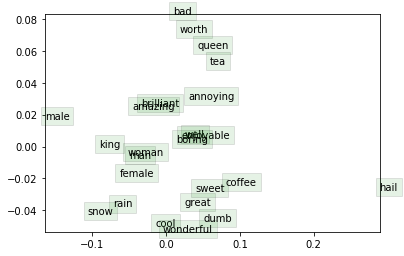

In [14]:
%matplotlib inline
plt.figure()
for i in range(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i],
        bbox=dict(facecolor='green', alpha=0.1))

plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))
plt.show()

# References
- 1- https://arxiv.org/pdf/1301.3781.pdf
- 2- http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf